<a href="https://colab.research.google.com/github/zorrento/task_for_sber_eapteka/blob/main/4task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

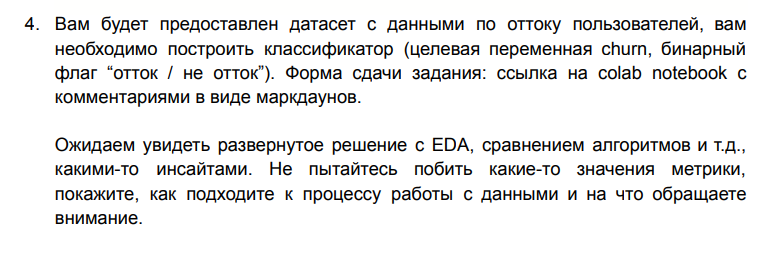

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

##Работа с данными

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/SberEapteka/churn_dataset.csv')

In [ ]:
data.shape #размерность датасета

(100000, 100)

In [ ]:
data.dtypes.value_counts() #количество фич разного типа

float64    69
object     21
int64      10
dtype: int64

21 фича типа Object - в дальнейшем подвергнутся декодированию.

Какое соотношение данных в плане "отток"/"не отток"?

In [ ]:
data['churn'].mean()#соотношение примерно равное

0.49562

Необходимо узнать количество записей в каждой колонке. Есть ли пропущенные данные?

In [ ]:
data.info() #описание данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

In [ ]:
print(data['Customer_ID'].nunique()) #можно удалить данный столбец, т.к. он не несет информационной ценности

100000


In [ ]:
data = data.drop('Customer_ID', axis=1)

Есть фичи (ownrent, non-null, object, lor, non-null, float64, dwlltype и т.д.), у которых отсутствует значительная часть данных. Поэтому отбросим фичи, по которым есть меньше 95к записей:

In [ ]:
cols = []
for i in data.columns:
  if data[i].notna().sum() > 95000:
    cols.append(i)

In [ ]:
new_data = data[cols].dropna().copy()#в дополнение к этому отбросим строки, в которых отсутствуют данные по каким-либо столбцам

In [ ]:
new_data.shape

(93893, 88)

Сколько уникальных значений у категориальных фичей?

In [ ]:
columns_obj = []
for i in new_data.columns:
  if new_data[i].dtypes == 'object':
    print(i, '\t', type(new_data[i].dtypes), '\t', new_data[i].nunique())
    columns_obj.append(i)

new_cell 	 <class 'numpy.dtype[object_]'> 	 3
crclscod 	 <class 'numpy.dtype[object_]'> 	 53
asl_flag 	 <class 'numpy.dtype[object_]'> 	 2
area 	 <class 'numpy.dtype[object_]'> 	 19
dualband 	 <class 'numpy.dtype[object_]'> 	 3
refurb_new 	 <class 'numpy.dtype[object_]'> 	 2
marital 	 <class 'numpy.dtype[object_]'> 	 5
ethnic 	 <class 'numpy.dtype[object_]'> 	 17
kid0_2 	 <class 'numpy.dtype[object_]'> 	 2
kid3_5 	 <class 'numpy.dtype[object_]'> 	 2
kid6_10 	 <class 'numpy.dtype[object_]'> 	 2
kid11_15 	 <class 'numpy.dtype[object_]'> 	 2
kid16_17 	 <class 'numpy.dtype[object_]'> 	 2
creditcd 	 <class 'numpy.dtype[object_]'> 	 2


Проверим, есть ли "бесполезные" категориальные фичи (со значительным перевесом в одну категорию, не несущие информационной ценности)

In [ ]:
columns_obj.remove('crclscod')#не хочется видеть подсчет по 53-м категориям (он будет отдельно ниже)

In [ ]:
for i in columns_obj:
  print(i, '\n', new_data[i].value_counts(), '\n')

new_cell 
 U    62367
Y    18375
N    13151
Name: new_cell, dtype: int64 

asl_flag 
 N    81528
Y    12365
Name: asl_flag, dtype: int64 

area 
 NEW YORK CITY AREA               10547
DC/MARYLAND/VIRGINIA AREA         6129
LOS ANGELES AREA                  6083
MIDWEST AREA                      5992
SOUTHWEST AREA                    5740
ATLANTIC SOUTH AREA               5719
CALIFORNIA NORTH AREA             5629
DALLAS AREA                       5154
NEW ENGLAND AREA                  5152
CHICAGO AREA                      4849
GREAT LAKES AREA                  4398
OHIO AREA                         4331
NORTHWEST/ROCKY MOUNTAIN AREA     4071
NORTH FLORIDA AREA                4062
CENTRAL/SOUTH TEXAS AREA          4013
HOUSTON AREA                      3970
SOUTH FLORIDA AREA                3154
TENNESSEE AREA                    2581
PHILADELPHIA AREA                 2319
Name: area, dtype: int64 

dualband 
 Y    68566
N    21406
T     3921
Name: dualband, dtype: int64 

refurb_new 

Графическое изображение того, как соотносится каждая фича с целевой переменной:

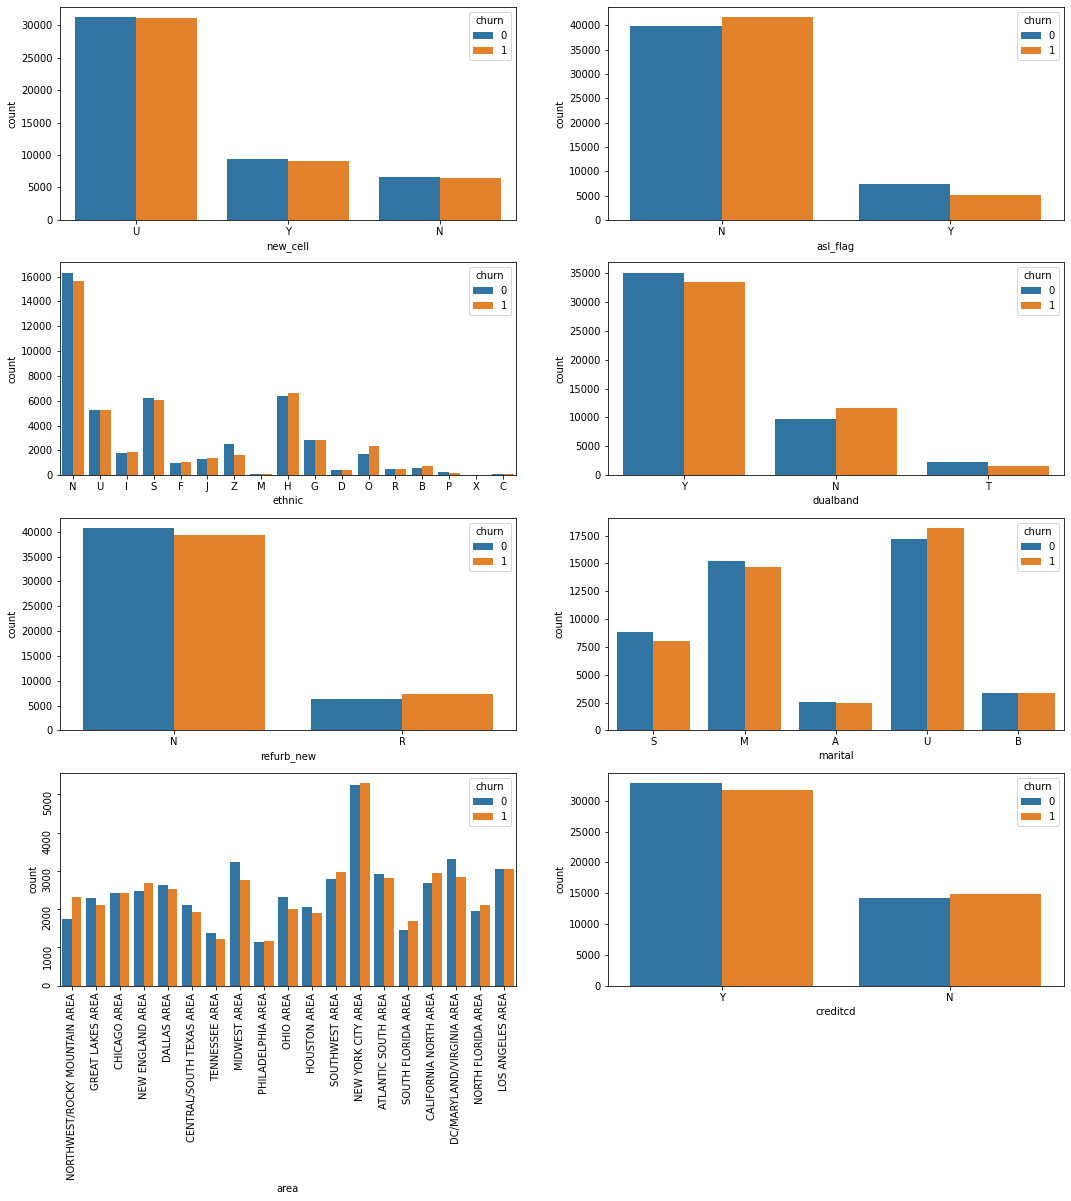

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(18,18))
ax[3][0].tick_params(labelrotation=90)
sns.countplot(x= "new_cell", hue="churn", data=new_data, ax=ax[0][0])
sns.countplot(x= "asl_flag", hue="churn", data=new_data, ax=ax[0][1])
sns.countplot(x= "ethnic", hue="churn", data=new_data, ax=ax[1][0])
sns.countplot(x= "dualband", hue="churn", data=new_data, ax=ax[1][1])
sns.countplot(x= "refurb_new", hue="churn", data=new_data, ax=ax[2][0])
sns.countplot(x= "marital", hue="churn", data=new_data, ax=ax[2][1])
sns.countplot(x= "area", hue="churn", data=new_data, ax=ax[3][0])
sns.countplot(x= "creditcd", hue="churn", data=new_data, ax=ax[3][1])

По некоторым признакам можно "усилить" эффект соотношения с целевой переменной "churn", объединив некоторые категории в одну:

In [ ]:
new_data_copy = new_data.copy()

In [ ]:
#объединим значения "N", "S", "Z", ..., в "NSZPXC"
new_data_copy.loc[new_data_copy['ethnic'] == 'N', 'ethnic'] = 'NSZPXC'
new_data_copy.loc[new_data_copy['ethnic'] == 'S', 'ethnic'] = 'NSZPXC'
new_data_copy.loc[new_data_copy['ethnic'] == 'Z', 'ethnic'] = 'NSZPXC'
new_data_copy.loc[new_data_copy['ethnic'] == 'P', 'ethnic'] = 'NSZPXC'
new_data_copy.loc[new_data_copy['ethnic'] == 'X', 'ethnic'] = 'NSZPXC'
new_data_copy.loc[new_data_copy['ethnic'] == 'C', 'ethnic'] = 'NSZPXC'

#same
new_data_copy.loc[new_data_copy['ethnic'] == 'I', 'ethnic'] = 'IJHDORB'
new_data_copy.loc[new_data_copy['ethnic'] == 'J', 'ethnic'] = 'IJHDORB'
new_data_copy.loc[new_data_copy['ethnic'] == 'H', 'ethnic'] = 'IJHDORB'
new_data_copy.loc[new_data_copy['ethnic'] == 'D', 'ethnic'] = 'IJHDORB'
new_data_copy.loc[new_data_copy['ethnic'] == 'O', 'ethnic'] = 'IJHDORB'
new_data_copy.loc[new_data_copy['ethnic'] == 'R', 'ethnic'] = 'IJHDORB'
new_data_copy.loc[new_data_copy['ethnic'] == 'B', 'ethnic'] = 'IJHDORB'

#same
new_data_copy.loc[new_data_copy['ethnic'] == 'U', 'ethnic'] = 'UFMG'
new_data_copy.loc[new_data_copy['ethnic'] == 'F', 'ethnic'] = 'UFMG'
new_data_copy.loc[new_data_copy['ethnic'] == 'M', 'ethnic'] = 'UFMG'
new_data_copy.loc[new_data_copy['ethnic'] == 'G', 'ethnic'] = 'UFMG'

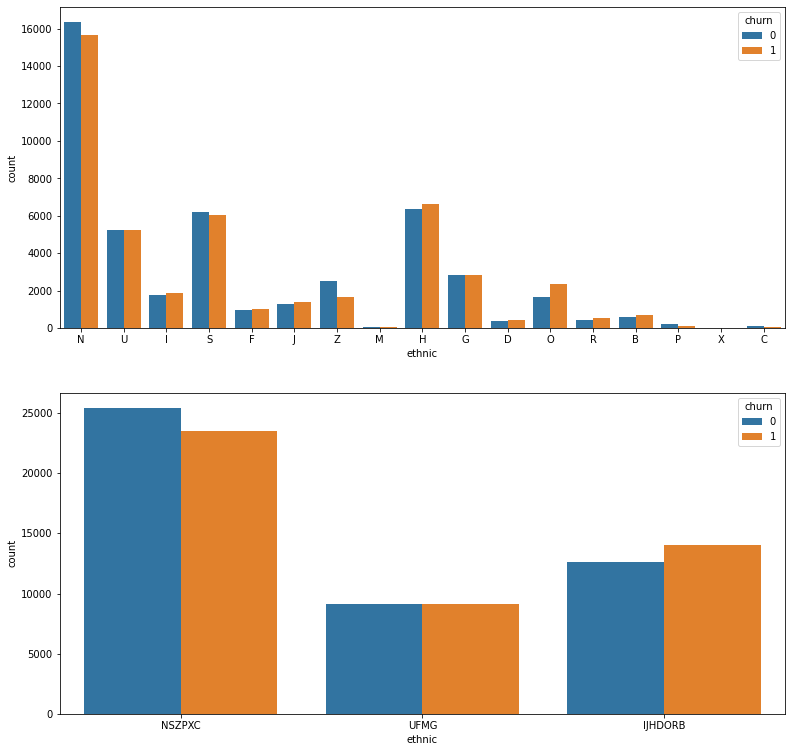

In [ ]:
#как внесенные изменения выглядят графически
fig, ax = plt.subplots(2, figsize=(13,13))
sns.countplot(x= "ethnic", hue="churn", data=new_data, ax=ax[0])
sns.countplot(x= "ethnic", hue="churn", data=new_data_copy, ax=ax[1])

In [ ]:
new_data_copy.loc[new_data_copy['marital'] == 'S', 'marital'] = 'SM'
new_data_copy.loc[new_data_copy['marital'] == 'M', 'marital'] = 'SM'

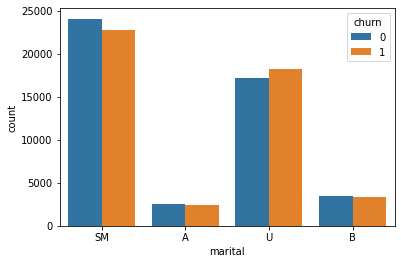

In [ ]:
sns.countplot(x='marital', hue='churn', data=new_data_copy)
plt.show()

Подозреваю, что kid<..>_<..> - разделенные фичи по одному и тому же признаку (наверное, наличие детей разного возраста). Что-то типа one-hot encoding, поэтому имеет место быть без изменений.

In [ ]:
new_data_copy['crclscod'].value_counts()

AA    34733
A     16374
BA    11820
CA     7767
EA     5955
B      3955
DA     3398
ZA     3271
C      1415
A2      801
E4      673
U       446
E       326
GA      254
D4      250
D       231
G       230
Z4      189
JF      187
Z       179
CY      171
M       162
C2      159
ZY      105
I       101
D5       92
W        91
C5       68
U1       63
B2       54
EM       52
Z5       45
V1       43
EC       36
GY       31
J        26
O        23
CC       22
E2       21
K        15
Z1       11
Y        11
H         8
D2        5
TP        5
Z2        5
A3        3
P1        3
IF        3
EF        2
V         1
ZF        1
L         1
Name: crclscod, dtype: int64

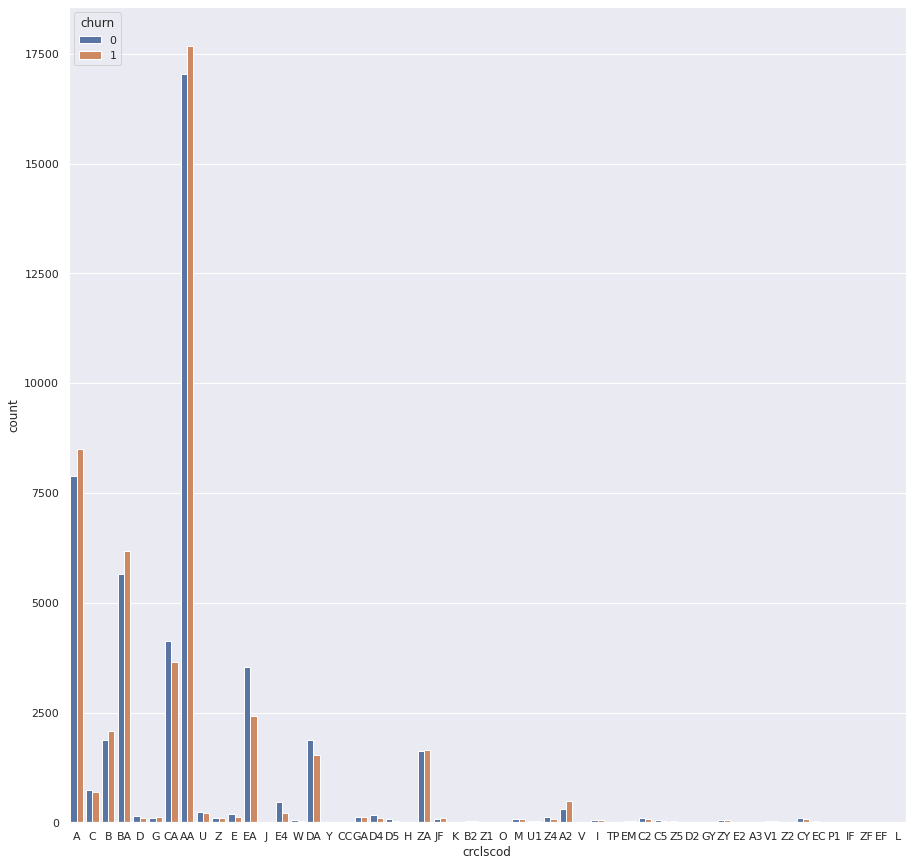

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
sns.countplot(x= "crclscod", hue="churn", data=new_data_copy)
plt.show()

In [ ]:
#также объединяем категории по "схожести" соотношения с целевой переменной
new_data_copy.loc[new_data_copy['crclscod'] == 'A', 'crclscod'] = 'AB'
new_data_copy.loc[new_data_copy['crclscod'] == 'B', 'crclscod'] = 'AB'
new_data_copy.loc[new_data_copy['crclscod'] == 'BA', 'crclscod'] = 'AB'
new_data_copy.loc[new_data_copy['crclscod'] == 'A2', 'crclscod'] = 'AB'
new_data_copy.loc[new_data_copy['crclscod'] == 'G', 'crclscod'] = 'AB'

new_data_copy.loc[new_data_copy['crclscod'] == 'C', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'D', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'CA', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'U', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'E', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'EA', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'E4', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'DA', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'D4', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'Z4', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'C2', 'crclscod'] = 'CD'
new_data_copy.loc[new_data_copy['crclscod'] == 'CY', 'crclscod'] = 'CD'

to_one_category = ['Z', 'J', 'W', 'Y', 'CC', 'GA', 'D5', 'H', 'ZA',\
                   'JF', 'K', 'B2', 'Z1', 'O', 'M', 'U1', 'V', 'I',\
                   'TP', 'EM', 'C5', 'Z5', 'D2', 'GY', 'ZY', 'E2',\
                   'A3', 'V1', 'Z2', 'EC', 'P1', 'IF', 'ZF', 'EF', 'L']
new_data_copy.loc[new_data_copy['crclscod'].isin(to_one_category), 'crclscod'] = 'ZJ'

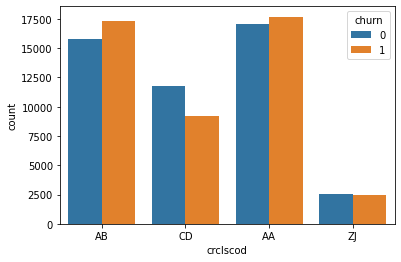

In [ ]:
sns.reset_orig()
sns.countplot(x='crclscod', hue='churn', data=new_data_copy)
plt.show()

In [ ]:
new_data = new_data_copy

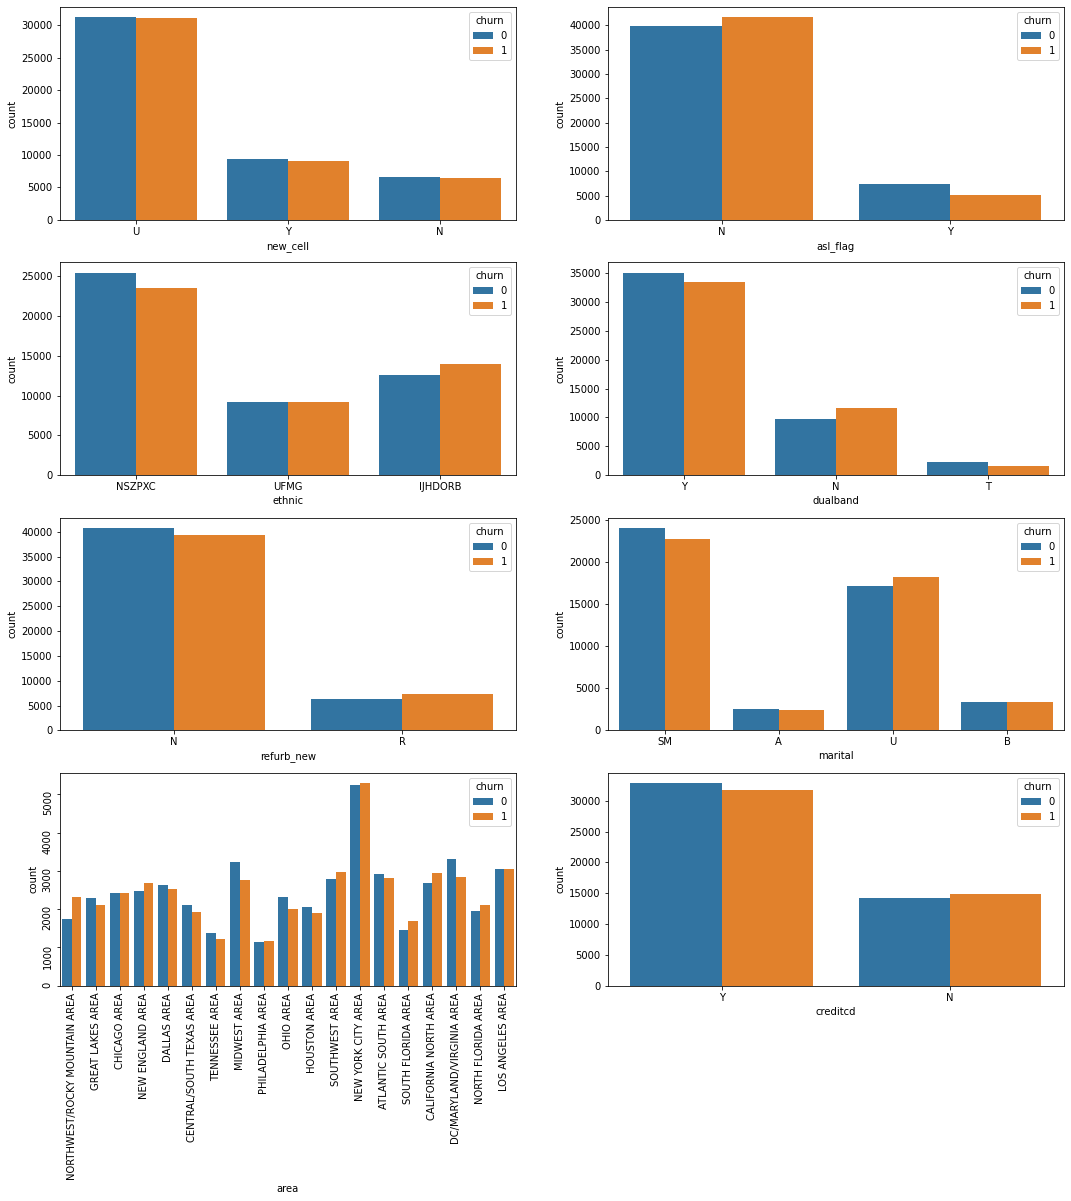

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(18,18))
ax[3][0].tick_params(labelrotation=90)
sns.countplot(x= "new_cell", hue="churn", data=new_data, ax=ax[0][0])
sns.countplot(x= "asl_flag", hue="churn", data=new_data, ax=ax[0][1])
sns.countplot(x= "ethnic", hue="churn", data=new_data, ax=ax[1][0])
sns.countplot(x= "dualband", hue="churn", data=new_data, ax=ax[1][1])
sns.countplot(x= "refurb_new", hue="churn", data=new_data, ax=ax[2][0])
sns.countplot(x= "marital", hue="churn", data=new_data, ax=ax[2][1])
sns.countplot(x= "area", hue="churn", data=new_data, ax=ax[3][0])
sns.countplot(x= "creditcd", hue="churn", data=new_data, ax=ax[3][1])

Графическое представление числовых данных:

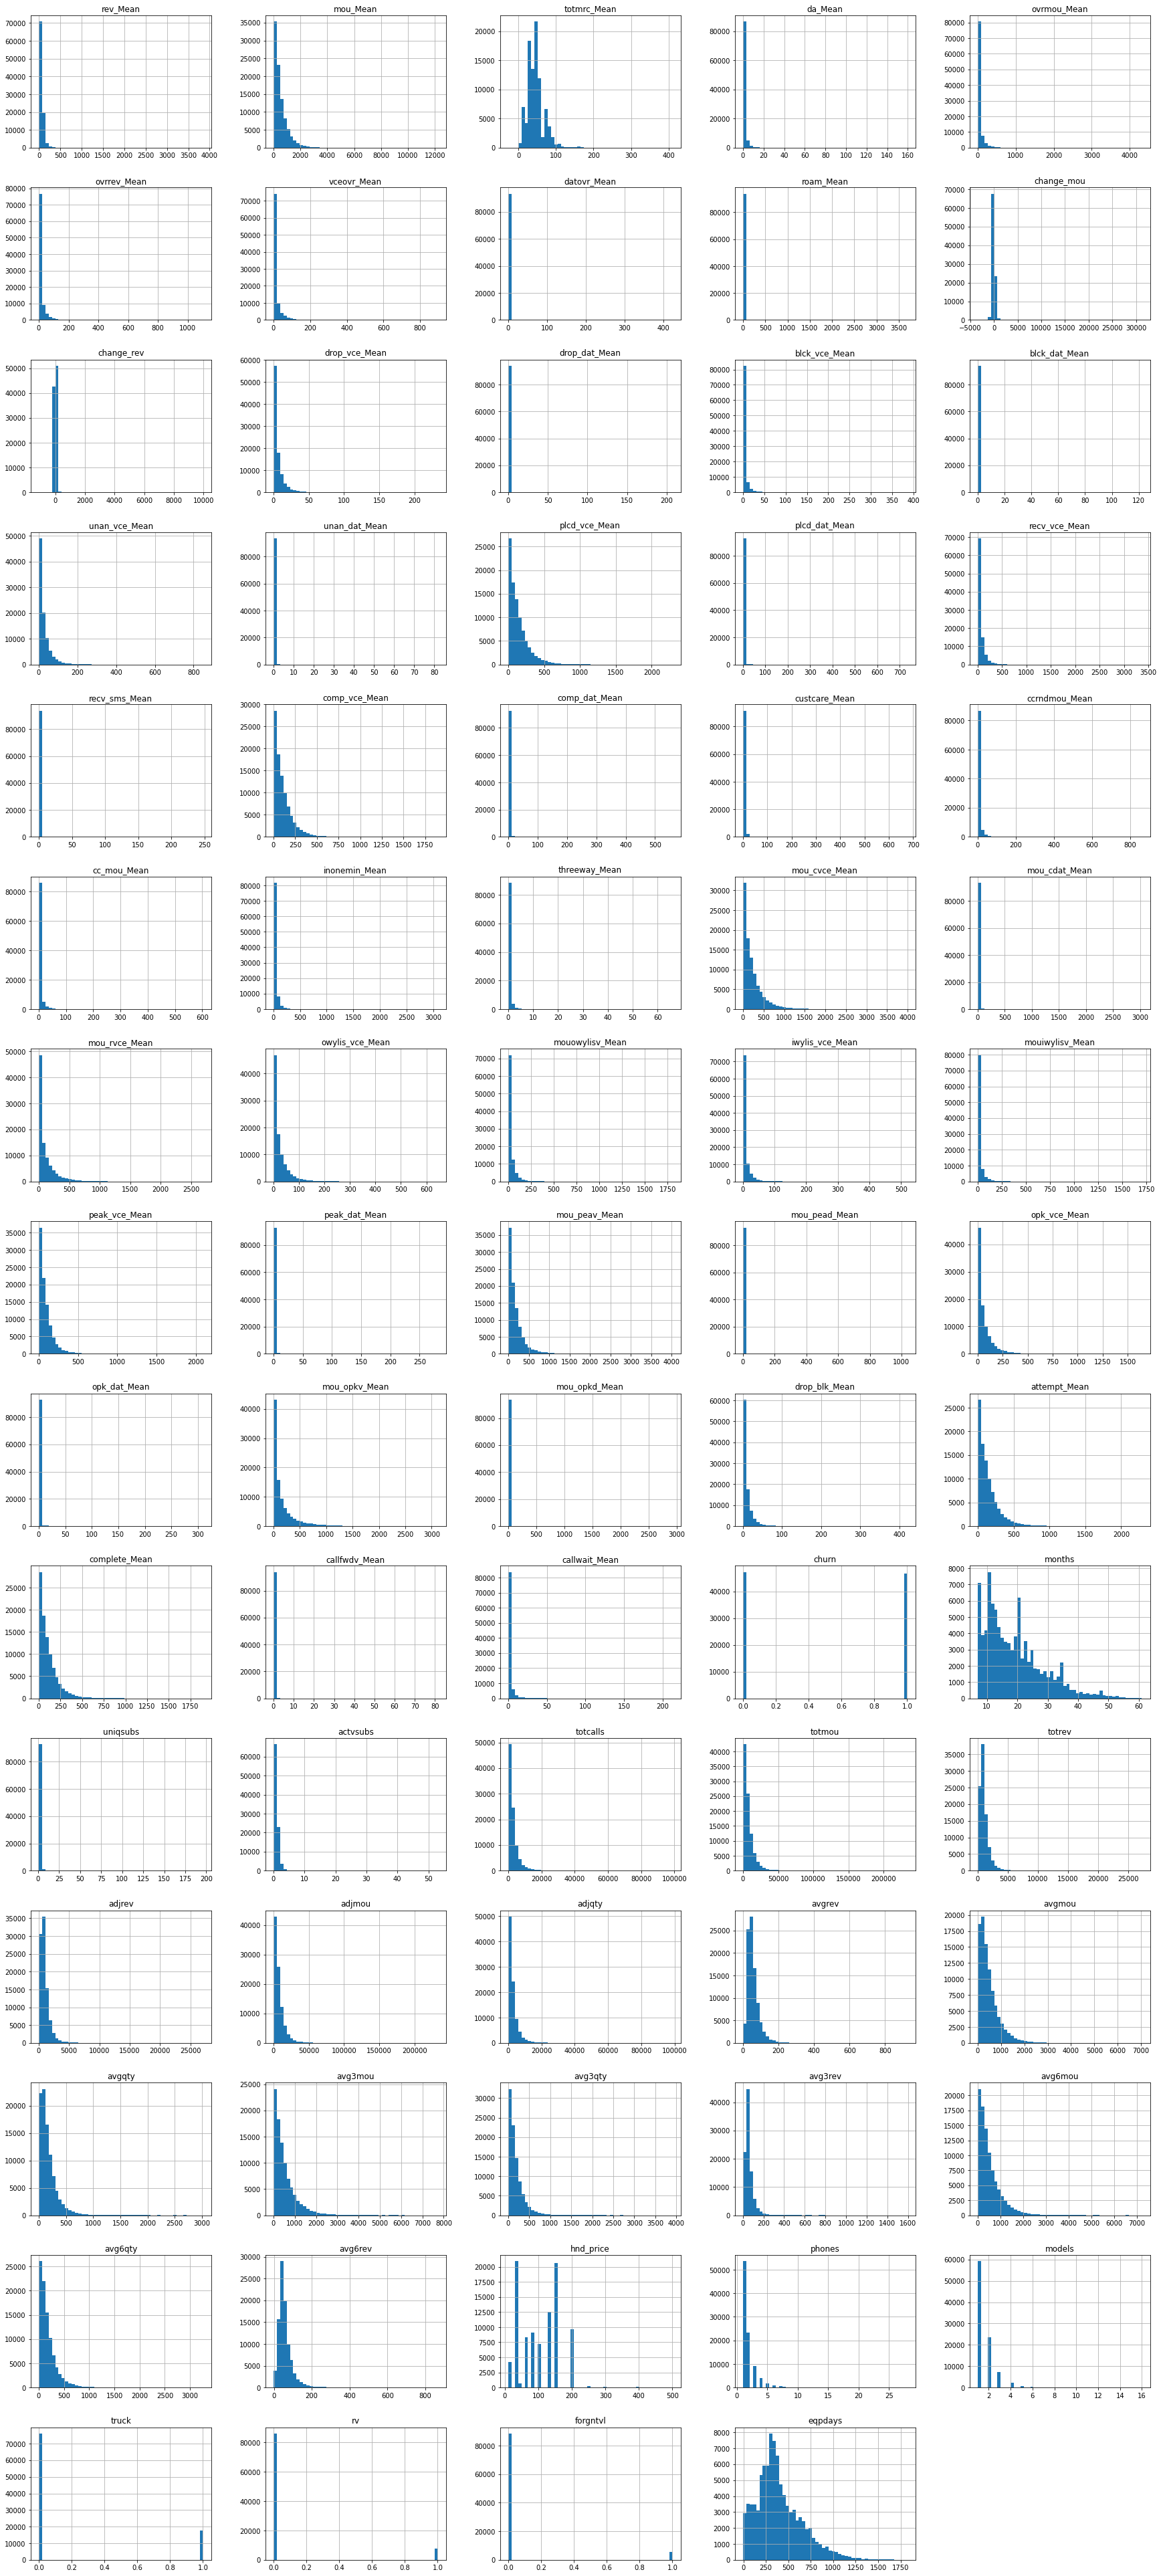

In [ ]:
new_data.hist(bins=50, layout=(15,5), figsize=(30,70));

По многим фичам данные имеют геометрическое распределение

Построим боксплоты для определения выбросов

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_feats = new_data.drop('churn', axis=1).select_dtypes(include=numerics).columns

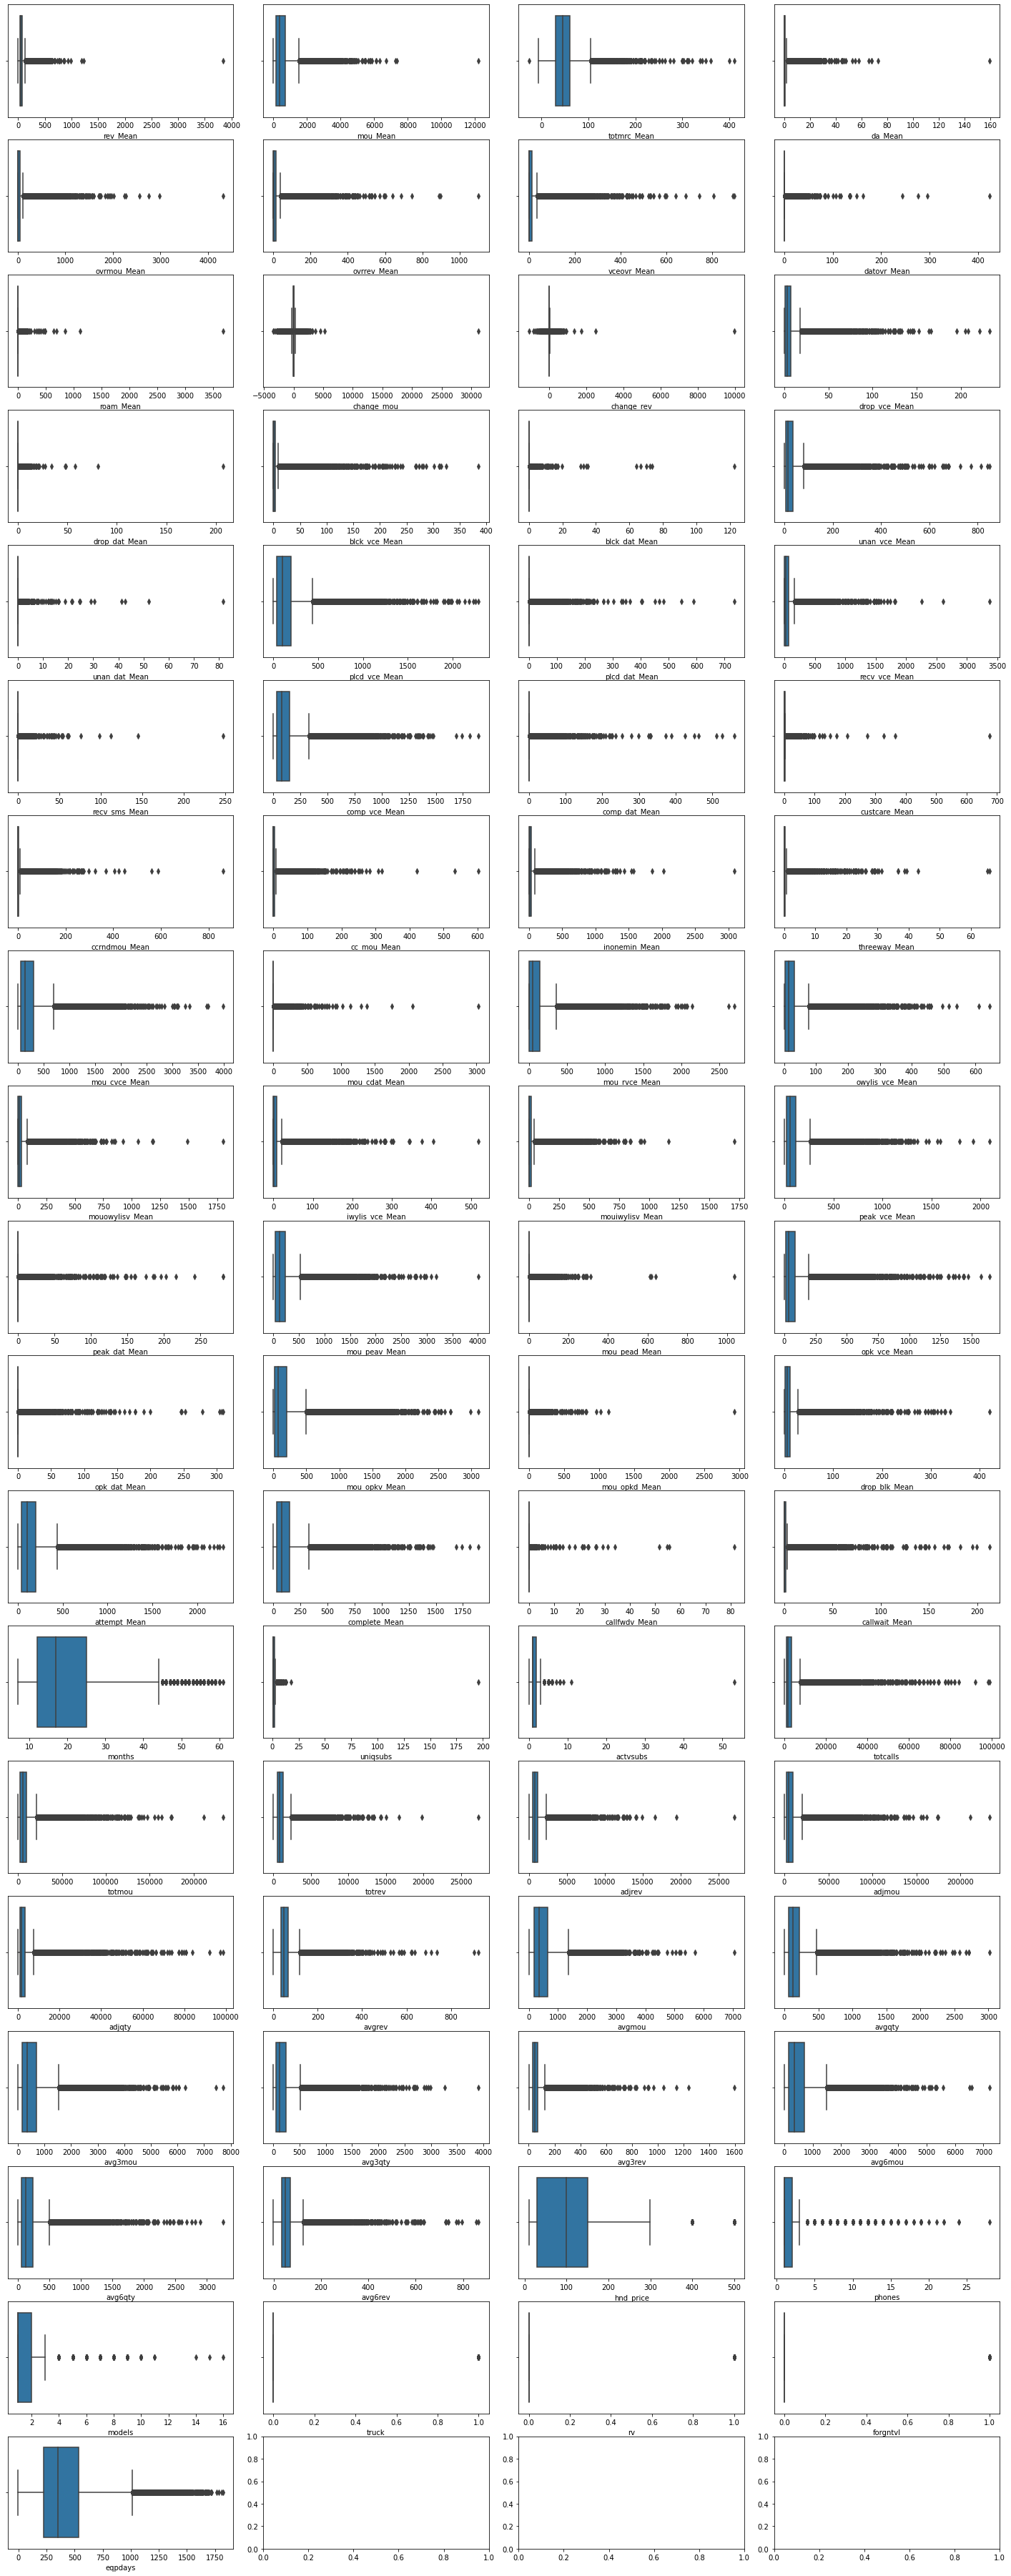

In [ ]:
fig, ax = plt.subplots(19, 4, figsize = (20, 50))
ax = ax.flatten()
fig.tight_layout()
for i, c in enumerate(num_feats):
    sns.boxplot(x = new_data[c], ax = ax[i])

In [ ]:
cols_for_outlier = ['months', 'actvsubs', 'hnd_price']#определил строчки для удаления выбросов - не много значений за "усами"

Избавимся от выбросов

In [ ]:
outlier_indexes = []
for i in cols_for_outlier:
  Q1 = np.percentile(new_data[i], 25)
  Q3 = np.percentile(new_data[i], 75)
  IQR = Q3 - Q1
  step = IQR * 1.5
  outlier_indexes.append(list(new_data[new_data[i] > (Q3 + step)].index))
outlier_indexes = [item for sublist in outlier_indexes for item in sublist]#делаем наш list flat
outlier_indexes = list(sorted(set(outlier_indexes)))
data = new_data[~new_data.index.isin(outlier_indexes)]

In [ ]:
data.shape

(90745, 88)

Кодирование категориальных переменных One-hot encoding-ом:

In [ ]:
columns_obj = []
for i in data.columns:
  if data[i].dtypes == 'object':
    columns_obj.append(i)
copied_data = data.copy()
copied_data = pd.get_dummies(copied_data, columns=columns_obj)

In [ ]:
data.shape

(90745, 88)

In [ ]:
copied_data.shape

(90745, 126)

## Построение модели

In [ ]:
SS = StandardScaler()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(copied_data.drop('churn', axis=1), copied_data['churn'], test_size=0.25, random_state=42)
X_train_scaled = SS.fit_transform(X_train)
X_test_scaled = SS.fit_transform(X_test)

Выбрал три модели для обучения: Логрег, Случайный лес, Дерево решений

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Logistic Regression

In [ ]:
logreg = LogisticRegression(random_state = 42, penalty = 'l2', max_iter=500)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [ ]:
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)
print("Accuracy (Log_Reg):", accuracy_score(y_test, y_pred))
print("Precision (Log_Reg):", precision_score(y_test, y_pred))
print("Recall (Log_Reg):", recall_score(y_test, y_pred))
print("ROC AUC (Log_Reg):", roc_auc_score(y_test, y_pred_proba[:,1]))

Accuracy (Log_Reg): 0.5878697051174682
Precision (Log_Reg): 0.5818071347973266
Recall (Log_Reg): 0.596617712505563
ROC AUC (Log_Reg): 0.6233226791619237


Random Forest

In [ ]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = RF.predict(X_test_scaled)
y_pred_proba = RF.predict_proba(X_test_scaled)
print("Accuracy (RF):", accuracy_score(y_test, y_pred))
print("Precision (RF):", precision_score(y_test, y_pred))
print("Recall (RF):", recall_score(y_test, y_pred))
print("ROC AUC (RF):", roc_auc_score(y_test, y_pred_proba[:,1]))

Accuracy (RF): 0.6119363512143519
Precision (RF): 0.6071774975751697
Recall (RF): 0.6129060970182465
ROC AUC (RF): 0.6584008234831991


Decision Tree

In [ ]:
DTC = DecisionTreeClassifier(random_state=42)
DTC.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = DTC.predict(X_test_scaled)
y_pred_proba = DTC.predict_proba(X_test_scaled)
print("Accuracy (DTC):", accuracy_score(y_test, y_pred))
print("Precision (DTC):", precision_score(y_test, y_pred))
print("Recall (DTC):", recall_score(y_test, y_pred))
print("ROC AUC (DTC):", roc_auc_score(y_test, y_pred_proba[:,1]))

Accuracy (DTC): 0.5452461762242694
Precision (DTC): 0.5401785714285714
Recall (DTC): 0.5492656875834446
ROC AUC (DTC): 0.5452842583917922


Random Forest показал себя лучше

## Post-modeling

Интересно взглянуть на "важность" фич (может помочь с потенциальным feature engineering-ом):

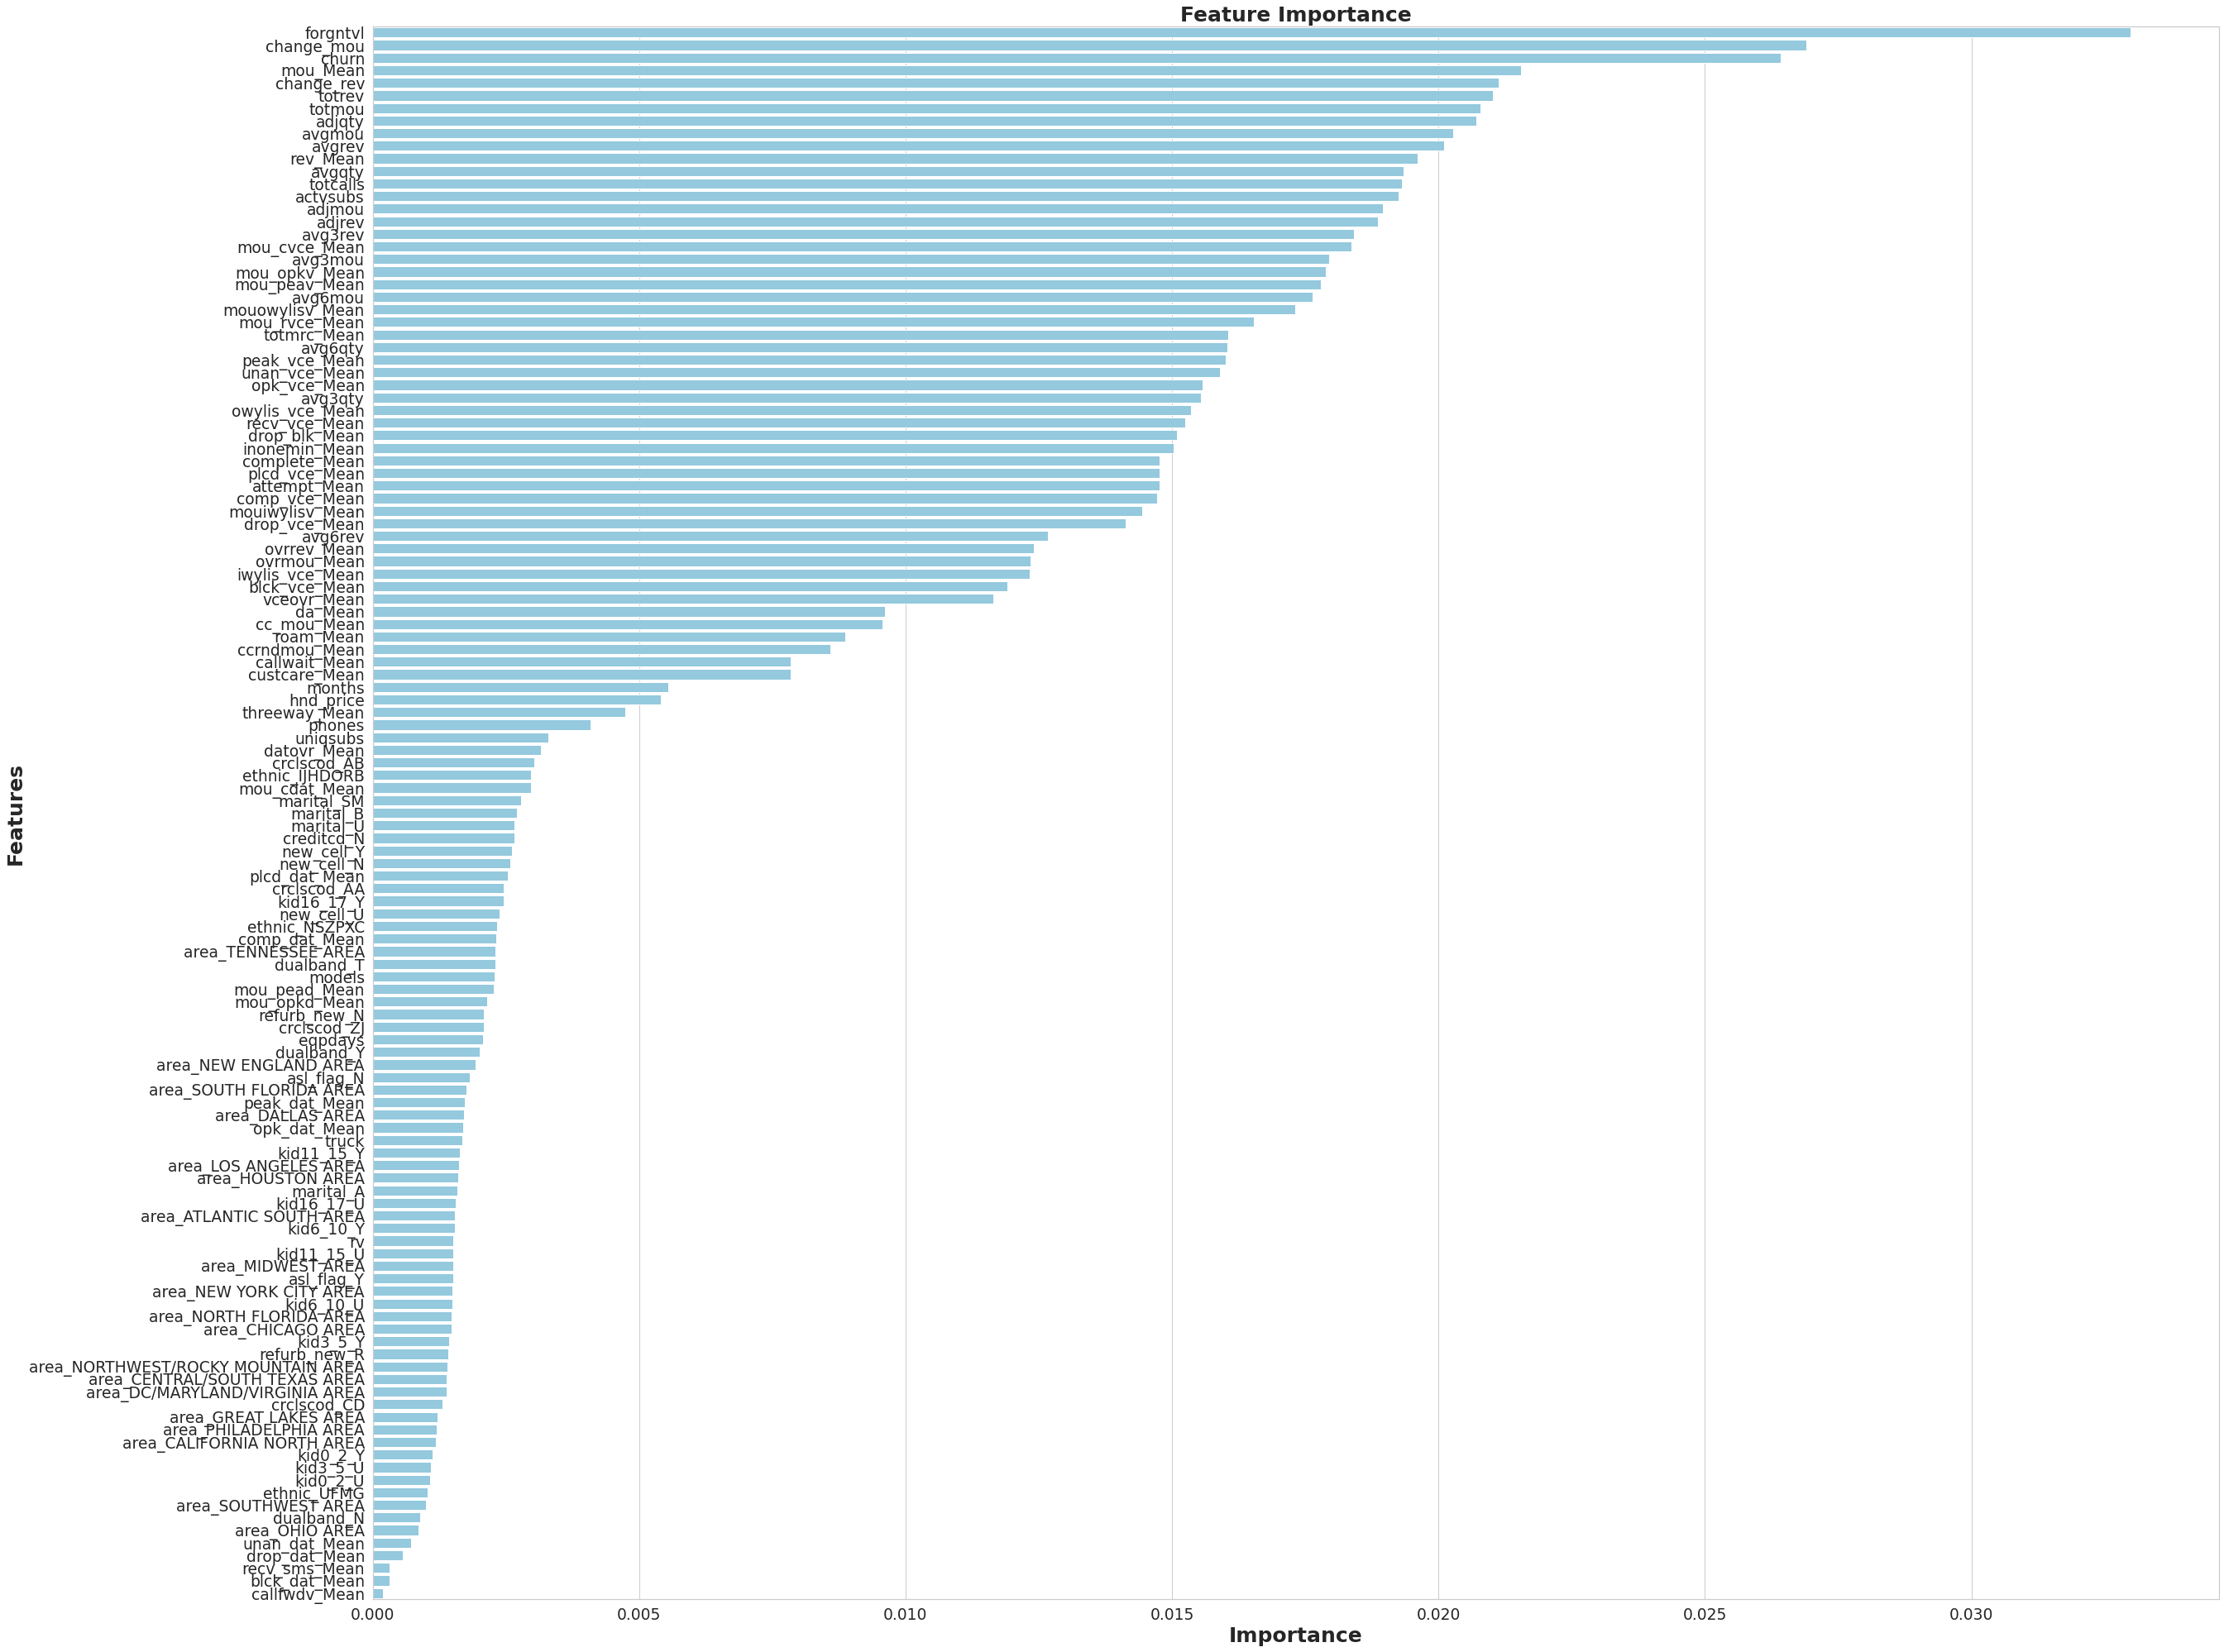

None

,Features,Gini-Importance
0,forgntvl,0.032991
1,change_mou,0.026904
2,churn,0.026427
3,mou_Mean,0.021543
4,change_rev,0.021134
...,...,...
120,unan_dat_Mean,0.000718
121,drop_dat_Mean,0.000572
122,recv_sms_Mean,0.000319
123,blck_dat_Mean,0.000314


In [ ]:
feats = {}
for feature, importance in zip(copied_data.columns, RF.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 2)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(40,35)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Метод главных компонент

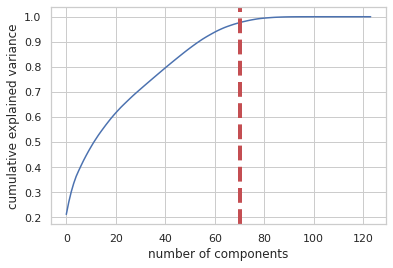

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.211839,0.211839
1,0.260929,0.049090
2,0.301977,0.041049
3,0.335745,0.033768
4,0.363785,0.028040
...,...,...
65,0.960851,0.003710
66,0.964306,0.003455
67,0.967669,0.003363
68,0.970808,0.003139


In [ ]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=124)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=70, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(70))

Опираясь на эти данные, можем сделать вывод, что нам будет достаточно 70 компонент, чтобы описать дисперсию на ~97%

In [ ]:
pca = PCA(n_components=70)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=copied_data.drop('churn', axis=1).columns, index=pca_dims)
pca_test_df.head(70).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9,...,PCA Component 60,PCA Component 61,PCA Component 62,PCA Component 63,PCA Component 64,PCA Component 65,PCA Component 66,PCA Component 67,PCA Component 68,PCA Component 69
rev_Mean,0.139045,0.012737,-0.049172,0.035318,0.304628,0.050508,-0.015533,0.090305,0.067695,0.108991,...,0.036640,-0.007024,-0.009203,0.009542,0.011373,-0.025706,-0.024232,0.007525,-0.021453,0.081382
mou_Mean,0.178686,-0.000120,0.029670,-0.032546,0.056396,-0.020926,-0.001624,-0.003513,0.031963,-0.009167,...,0.017007,0.093829,-0.020372,0.003641,0.005870,-0.001320,-0.061186,0.002401,-0.025017,0.087753
totmrc_Mean,0.117087,0.001170,-0.025179,0.047354,0.066993,0.064567,-0.122502,-0.102434,-0.061190,-0.027096,...,-0.108424,0.050794,0.017675,0.015560,0.010586,-0.097759,-0.145190,0.012055,-0.000866,0.186335
da_Mean,0.084811,-0.009770,-0.035930,0.025601,0.083855,0.048583,-0.019554,-0.010032,-0.015752,-0.012931,...,0.128329,0.435122,-0.065290,-0.038909,-0.126195,-0.120034,0.052246,0.053532,-0.125015,0.081967
ovrmou_Mean,0.115529,0.013923,-0.032020,-0.001872,0.328177,-0.011797,0.081606,0.138626,0.053258,0.052486,...,-0.031157,-0.026338,0.023604,-0.001923,0.005132,0.053454,-0.007233,-0.016358,0.018538,-0.014772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kid11_15_Y,-0.008897,-0.008541,-0.132561,-0.238688,-0.028184,0.017432,-0.178172,0.148398,-0.082496,0.151115,...,0.008003,0.001969,-0.004005,0.003179,-0.003574,-0.002008,-0.000540,-0.003524,0.003915,-0.002249
kid16_17_U,0.002735,0.003384,0.103848,0.220448,0.041528,0.071853,0.236411,-0.180504,0.056362,-0.076427,...,-0.000765,-0.013282,-0.005671,0.004330,-0.010977,-0.017089,0.000400,0.003794,0.005608,0.011849
kid16_17_Y,-0.002735,-0.003384,-0.103848,-0.220448,-0.041528,-0.071853,-0.236411,0.180504,-0.056362,0.076427,...,0.000765,0.013282,0.005671,-0.004330,0.010977,0.017089,-0.000400,-0.003794,-0.005608,-0.011849
creditcd_N,0.027448,0.020115,0.224932,0.223364,-0.004862,0.024289,-0.002980,-0.036487,-0.015090,0.168024,...,-0.376909,0.074185,-0.012114,-0.035522,0.044008,0.012323,0.002796,-0.005359,-0.002708,0.003495


In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled_pca, y_train)
display(rfc.score(X_train_scaled_pca, y_train))

1.0

In [ ]:
preds_pca = rfc.predict(X_test_scaled_pca)
preds_proba_pca = rfc.predict_proba(X_test_scaled_pca)

In [ ]:
print("Accuracy (rfc after PCA):", accuracy_score(y_test, preds_pca))
print("Precision (rfc after PCA):", precision_score(y_test, preds_pca))
print("Recall (rfc after PCA):", recall_score(y_test, preds_pca))
print("ROC AUC (rfc after PCA):", roc_auc_score(y_test, preds_proba_pca[:,1]))

Accuracy (rfc after PCA): 0.5698417595980076
Precision (rfc after PCA): 0.5680184331797234
Recall (rfc after PCA): 0.5485536270582999
ROC AUC (rfc after PCA): 0.5957397459817966


In [ ]:
y_pred = RF.predict(X_test_scaled)
y_pred_proba = RF.predict_proba(X_test_scaled)
print("Accuracy (RF):", accuracy_score(y_test, y_pred))
print("Precision (RF):", precision_score(y_test, y_pred))
print("Recall (RF):", recall_score(y_test, y_pred))
print("ROC AUC (RF):", roc_auc_score(y_test, y_pred_proba[:,1]))

Accuracy (RF): 0.6119363512143519
Precision (RF): 0.6071774975751697
Recall (RF): 0.6129060970182465
ROC AUC (RF): 0.6584008234831991


Базовая модель Random Forest показала себя лучше чем модель с использованием главных компонент.

##Неактуально (построение первого бейзлайна)

In [ ]:
new_data.loc[new_data['new_cell'] == 'U', 'new_cell'] = 0
new_data.loc[new_data['new_cell'] == 'Y', 'new_cell'] = 1
new_data.loc[new_data['new_cell'] == 'N', 'new_cell'] = 2

In [ ]:
#преобразуем в два класса: =АА и !=АА
new_data.loc[new_data['crclscod'] != 'AA', 'crclscod'] = 0

In [ ]:
new_data.loc[new_data['crclscod'] == 'AA', 'crclscod'] = 1

In [ ]:
new_data['crclscod'] = new_data['crclscod'].astype('int')

In [ ]:
new_data.loc[new_data['asl_flag'] == 'N', 'asl_flag'] = 0
new_data.loc[new_data['asl_flag'] != 'Y', 'asl_flag'] = 1

In [ ]:
#encoding области
new_data.area = new_data.area.astype('category').cat.codes

In [ ]:
#encoding dualband
new_data.dualband = new_data.dualband.astype('category').cat.codes

In [ ]:
#encoding refurb_new
new_data.refurb_new = new_data.refurb_new.astype('category').cat.codes

In [ ]:
#encoding marital
new_data.marital = new_data.marital.astype('category').cat.codes

In [ ]:
#encoding forgntvl
new_data.forgntvl = new_data.forgntvl.astype('category').cat.codes

In [ ]:
for i in new_data.columns[-3:-10:-1]:
  new_data[i] = new_data[i].astype('category').cat.codes

In [ ]:
for i in ['new_cell', 'asl_flag']:
  new_data[i] = new_data[i].astype('category').cat.codes

In [ ]:
new_data.dtypes.value_counts()#не осталось ли object-типов

float64    64
int8       14
int64      11
dtype: int64

Рассмотрим информационную ценность каждого признака

In [ ]:
#для WOE биннинга признаков использую Xverse (https://towardsdatascience.com/introducing-xverse-a-python-package-for-feature-selection-and-transformation-17193cdcd067#:~:text=%E2%80%9CWeight%20of%20evidence%20(WOE),of%20good%20vs%20bad%20customers.%E2%80%9D)
!pip install xverse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xverse.transformer import WOE
clf_without = WOE()
clf_without.fit(new_data.drop('churn', axis=1), new_data['churn'])
clf_without.woe_df
print(clf_without.iv_df)#iv-dataset

    Variable_Name  Information_Value
37        eqpdays           0.080350
40      hnd_price           0.036854
81    totmrc_Mean           0.023335
6        asl_flag           0.019228
53  mou_cvce_Mean           0.016607
..            ...                ...
83          truck           0.000062
44       kid11_15           0.000052
19  callfwdv_Mean           0.000028
47        kid6_10           0.000011
77             rv           0.000006

[88 rows x 2 columns]


In [ ]:
#выберем для бейзлайна 4 первых признака
columns_bsln = ['eqpdays', 'hnd_price', 'totmrc_Mean', 'asl_flag']

Разбить на тренировочную и тестовую выборки и построить бейзлайн модель

In [ ]:
target = new_data['churn']
new_data_X = new_data[columns_bsln]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_data_X, target, test_size=0.3, random_state=42)

In [ ]:
#woe-трансформация
X_train = clf_without.transform(X_train)
X_test = clf_without.transform(X_test)

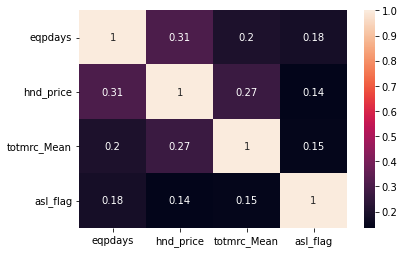

In [ ]:
sns.heatmap(X_train.corr(), annot=True)
plt.show()

In [ ]:
#model
logreg = LogisticRegression(random_state = 42, penalty = 'l2')
logreg.fit(X_train, y_train)
y_pred = logreg.predict_proba(X_test)[:,1]
y_pred_train = logreg.predict_proba(X_train)[:,1]
print("ROC AUC train:", roc_auc_score(y_train, y_pred_train))
print("ROC AUC val:", roc_auc_score(y_test, y_pred))

ROC AUC train: 0.5855440066268255
ROC AUC val: 0.584324191558706


In [ ]:
y_test_predicted = logreg.predict(X_test)
accuracy_score(y_test_predicted, y_test)

0.5664938937801761

In [ ]:
precision_score(y_test_predicted, y_test)

0.6851917739984345

In [ ]:
recall_score(y_test_predicted, y_test)

0.5528824069820855